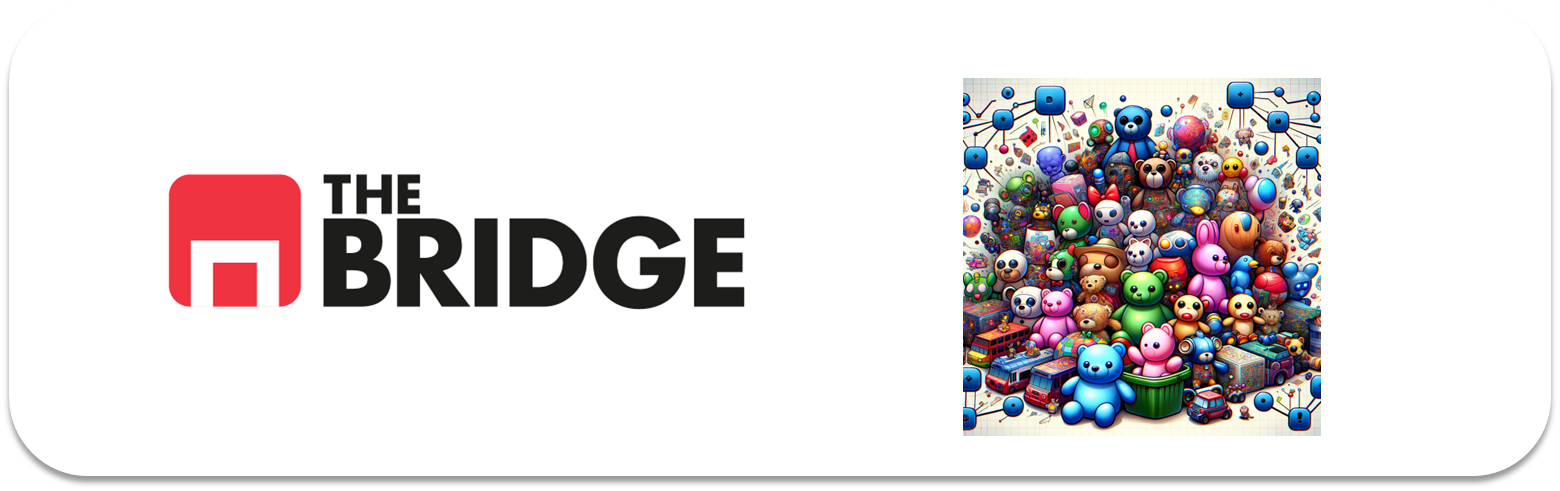

## PRACTICA OBLIGATORIA: **DBSCAN y Clustering Jerárquico**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score


### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


1. Entender el problema:

    - No hay target → problema no supervisado.
    - Queremos segmentar mezclas de bebidas según sus componentes.
    - Los químicos esperan entre 3 y 5 segmentos.
    - Piden:
        - DBSCAN (clustering por densidad).
        - Otro algoritmo: por enunciado y documentos → clustering jerárquico aglomerativo.

    - La comparación será especulativa porque:

        - No tenemos “verdad” de a qué cluster debería pertenecer cada mezcla.

    - Solo podemos juzgar por:
        - forma de los clusters,
        - coherencia química (que ellos interpretarán),
        - métricas internas (silueta, etc.), no externas.

2. Carga de datos 

In [2]:
df = pd.read_csv(
    "./data/empowering_drinks.csv",
    skip_blank_lines=True,
    on_bad_lines="skip",
    encoding="utf-8",
    sep='|'
)

df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


3. MiniEDA: Seleccion de features

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [4]:
df.describe()


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


- Todas las medias ≈ 0
- Todas las desviaciones estándar ≈ 1
- Rango entre -3 y +3

Esto significa que los datos parecen que ya están estandarizados.

- Todas las features son numéricas → No hay que codificar nada.
- Todas están parecen tener escalas similares → Perfecto para DBSCAN y jerárquico.
- No hay columnas inútiles → No hay IDs, ni columnas categóricas, ni columnas con varianza cero.
- No hay correlaciones obvias a simple vista → Lo normal será usar las 5 features completas.

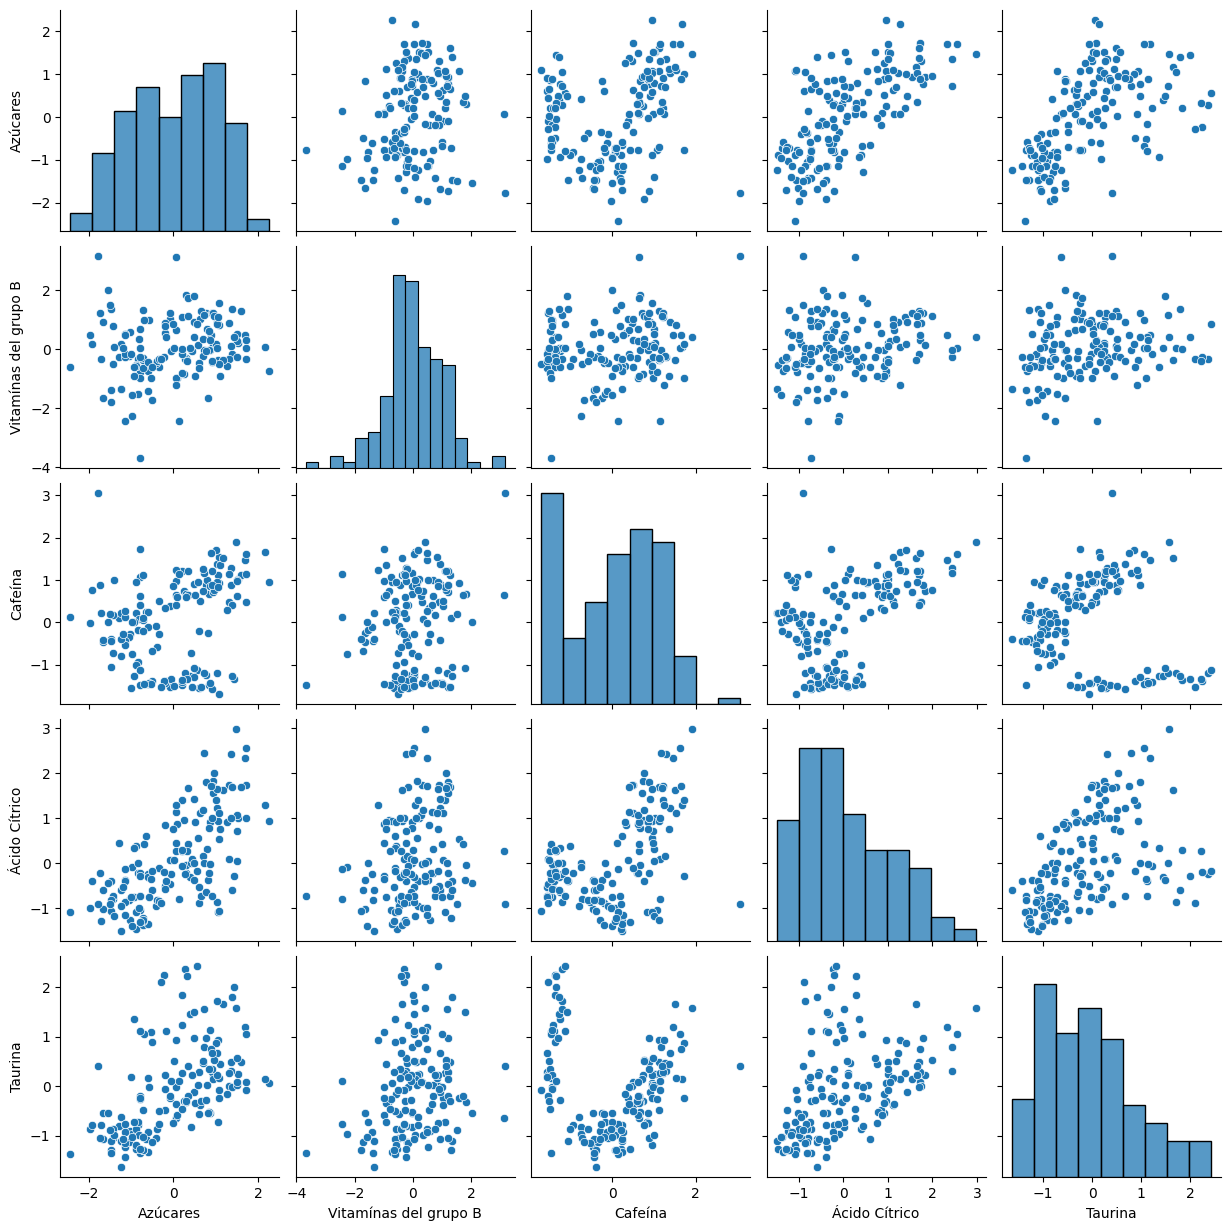

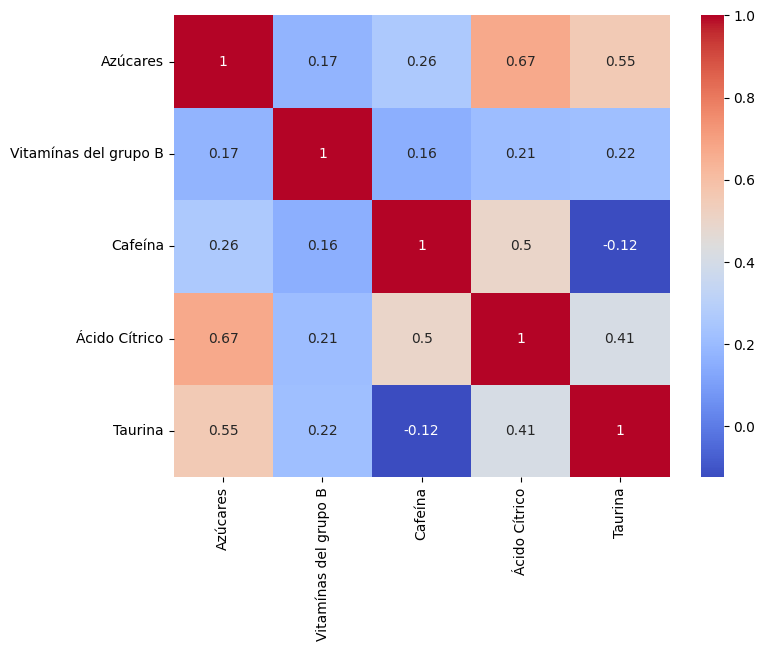

In [5]:
sns.pairplot(df)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()


Aquí ya se ve algo más interesante:

- Ácido Cítrico y Azúcares muestran una relación más marcada.
- Taurina también parece correlacionarse con Azúcares y Ácido Cítrico.
- Las nubes de puntos empiezan a mostrar formas ligeramente alargadas, lo cual es útil para clustering jerárquico y DBSCAN.

Conclusión:  
- No hay ninguna variable que “sobre”, y sí hay relaciones que pueden ayudar a formar clusters.

Correlaciones fuertes:
- Azúcares – Ácido Cítrico: 0.67
- Azúcares – Taurina: 0.55
- Cafeína – Ácido Cítrico: 0.50
- Ácido Cítrico – Taurina: 0.41

Correlaciones débiles:
- Vitaminas B con casi todo (0.16–0.22)
- Cafeína – Taurina: -0.12

Interpretación:

- No hay correlaciones tan altas como para eliminar variables (>0.9).
- Las correlaciones moderadas indican que las variables aportan información complementaria.
- Vitaminas B es la más “independiente”, lo cual es bueno para clustering.

5. Tratamiento de Features

In [6]:
X = df[["Azúcares", "Ácido Cítrico", "Taurina", "Cafeína", "Vitamínas del grupo B"]].values


In [7]:
X

array([[ 1.51861254e+00,  1.01300893e+00,  2.51716850e-01,
         1.03481896e+00,  2.32052541e-01],
       [ 2.46289627e-01,  9.65241521e-01, -2.93321329e-01,
         7.33628941e-01, -8.27996323e-01],
       [ 1.96879028e-01,  1.39514818e+00,  2.69019649e-01,
         1.21553297e+00,  1.10933436e+00],
       [ 1.69154964e+00,  2.33457383e+00,  1.18606801e+00,
         1.46652465e+00,  4.87926405e-01],
       [ 2.95700226e-01, -3.78740070e-02, -3.19275528e-01,
         6.63351271e-01,  1.84040254e+00],
       [ 1.71625494e+00,  1.72952002e+00,  8.30145565e-02,
         4.92676928e-01,  3.05159359e-01],
       [ 1.30861750e+00,  1.74544249e+00, -3.49944013e-03,
         4.82637261e-01,  8.90013905e-01],
       [ 2.25977152e+00,  9.49319052e-01,  6.13860573e-02,
         9.54501620e-01, -7.18336096e-01],
       [ 1.06156450e+00,  9.49319052e-01,  9.35177423e-01,
         1.12517596e+00, -3.52802005e-01],
       [ 1.35802810e+00,  2.43010864e+00,  2.99299548e-01,
         1.29585031e+00

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


6. Seleecion de modelo (Modelo de DBSCAN)

In [9]:
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 4, 5, 6]

results_dbscan = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            sil = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
        else:
            sil = np.nan

        print(f"eps={eps}, min_samples={ms} → clusters={n_clusters}, noise={n_noise}, sil={sil}")
        results_dbscan.append((eps, ms, n_clusters, n_noise, sil))


eps=0.3, min_samples=3 → clusters=0, noise=153, sil=nan
eps=0.3, min_samples=4 → clusters=0, noise=153, sil=nan
eps=0.3, min_samples=5 → clusters=0, noise=153, sil=nan
eps=0.3, min_samples=6 → clusters=0, noise=153, sil=nan
eps=0.5, min_samples=3 → clusters=8, noise=125, sil=0.5894552065133691
eps=0.5, min_samples=4 → clusters=3, noise=140, sil=0.6191395482705069
eps=0.5, min_samples=5 → clusters=0, noise=153, sil=nan
eps=0.5, min_samples=6 → clusters=0, noise=153, sil=nan
eps=0.7, min_samples=3 → clusters=9, noise=93, sil=0.41345495816368133
eps=0.7, min_samples=4 → clusters=7, noise=104, sil=0.4282868051475103
eps=0.7, min_samples=5 → clusters=3, noise=123, sil=0.6130970622496444
eps=0.7, min_samples=6 → clusters=2, noise=133, sil=0.7812318195223072
eps=1.0, min_samples=3 → clusters=4, noise=19, sil=0.3839181671679826
eps=1.0, min_samples=4 → clusters=4, noise=23, sil=0.3563660499093978
eps=1.0, min_samples=5 → clusters=3, noise=33, sil=0.45628983193127104
eps=1.0, min_samples=6 → cl

Cada parámetro y cada métrica:
- eps
    - Es el radio que define qué puntos se consideran “vecinos”.
        - Si eps es pequeño, solo puntos muy cercanos se agrupan → muchos puntos quedan como ruido.
        - Si eps es grande, se agrupan puntos más lejanos → clusters más grandes y menos ruido.

- En tus resultados:
    - Con eps = 0.3 → todo es ruido.
    - Con eps = 1.0 → clusters grandes y poco ruido.

- min_samples:
    - Es la densidad mínima para formar un cluster.

        - Si es pequeño (3), DBSCAN forma clusters más fácilmente.
        - Si es grande (6), exige más densidad → más ruido.

- clusters:
    - Es el número de clusters reales encontrados (sin contar el ruido).
- noise:
    - Cantidad de puntos etiquetados como -1, es decir, puntos que DBSCAN considera outliers.

- sil (silhouette score):
    - Mide qué tan bien separados están los clusters. Va de -1 a 1.
    - Cuanto más alto, mejor.
    - Se calcula solo con los puntos que NO son ruido.

- ¿Qué priorizamos?
    - Depende del objetivo:

        - Si quieres clusters muy bien separados → elige el mejor silueta
            
            - eps = 0.5, min_samples = 4  
            - Silhouette = 0.619  
            - Pero… casi todo es ruido (140 puntos).

    - Esto puede ser útil si quieres detectar mezclas “raras”.

- Si quieres clusters más completos y menos ruido → elige eps = 1.0
    
    - eps = 1.0, min_samples = 5
    - clusters = 3
    - noise = 33

    - silhouette = 0.456

- Es un equilibrio razonable:

    - 3 clusters (como pedían los químicos)
    - poco ruido
    - separación aceptable

De los resultados obtenidos elijo el que tiene eps=1, min_samples=5 y 3 clusters.¿Poque?:

1. Produce 3 clusters → dentro del rango esperado
- Los químicos dijeron explícitamente que esperan 3–5 segmentos.

2. Tiene poco ruido, solo 33 puntos quedan fuera.

- Esto permite que los químicos interpreten los clusters sin perder la mayoría de las mezclas.

3. Los clusters son más grandes y representativos
- Esto es clave para poder analizarlos químicamente después.

4. La silueta es razonable
- No es la mejor, pero es suficientemente buena para un clustering basado en densidad.

Entrenamiento, visualización de resultados.

In [10]:
best_eps = 1
best_min_samples = 5

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)


Visualización en PCA

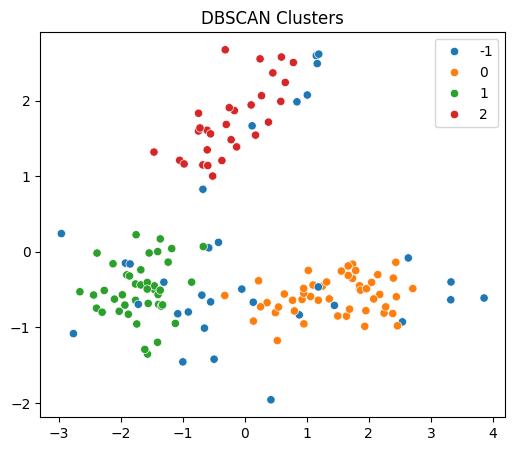

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dbscan_labels, palette="tab10")
plt.title("DBSCAN Clusters")
plt.show()


DBSCAN siempre genera una etiqueta especial:
- -1 → ruido (outliers)
- 0, 1, 2 → clusters reales

6.1. Model Jeraquico

¿Por qué ahora toca clustering jerárquico?
- El enunciado decía:

    - “Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cuál deberíamos usar dado el enunciado).”
    - Los químicos esperan entre 3 y 5 clusters.
    - Quieren poder interpretar relaciones entre segmentos (“cuáles segmentos se parecen más entre sí”).

- Y aquí está la clave:

    - El único algoritmo que permite ver relaciones entre clusters (quién se parece más a quién) es el clustering jerárquico, porque genera un dendrograma.
    - Por eso es el complemento perfecto de DBSCAN.

Para el Dendrograma:

- Ward + Euclidean es la combinación más estable.
- Tu dendrograma muestra 3 bloques muy claros → k = 3.

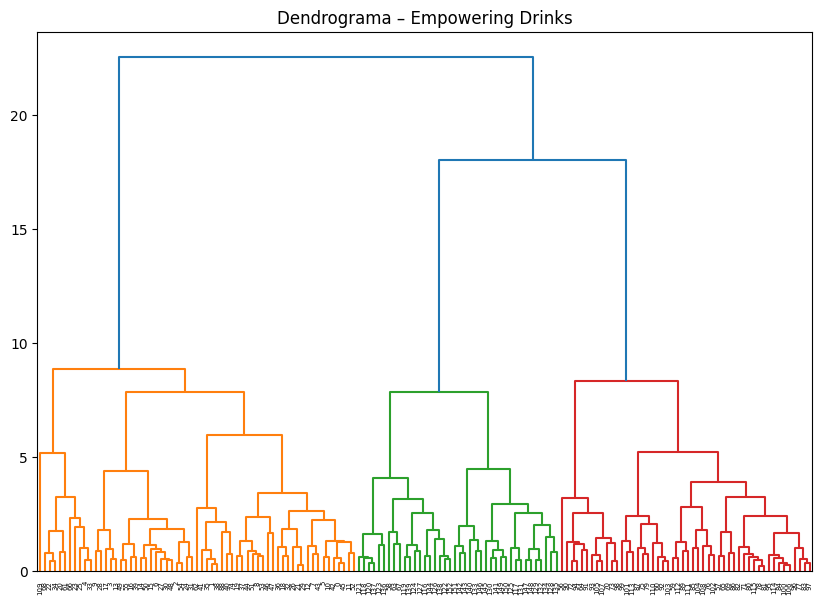

In [13]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10,7))
plt.title("Dendrograma – Empowering Drinks")
clusters = shc.linkage(X_scaled, method='ward', metric='euclidean')
shc.dendrogram(clusters)
plt.show()


El número de clusters adecuado es 3
Porque:

- El mayor salto vertical (el “gap”) está justo antes de que los tres bloques se unan.

- Cortar el dendrograma a esa altura produce 3 clusters bien separados.

- Coincide con la nota orientativa del enunciado: “Los químicos no esperan menos de 3 ni más de 5 segmentos.”

Tu dendrograma claramente favorece 3.

¿Podrías elegir 4 o 5 clusters?

Sí, pero:

- 4 y 5 aparecen como subdivisiones internas dentro de los bloques grandes.
- No son tan naturales como los 3 principales.
- La separación entre ellos es mucho menor.

Por eso, si quieres ser riguroso:

- k = 3 es la elección más sólida
- k = 4 o k = 5 serían alternativas válidas pero menos justificadas

6.2 Entrenar modelo jerárquico

In [14]:
agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
agg_labels = agg.fit_predict(X_scaled)


6.3 Visualización PCA

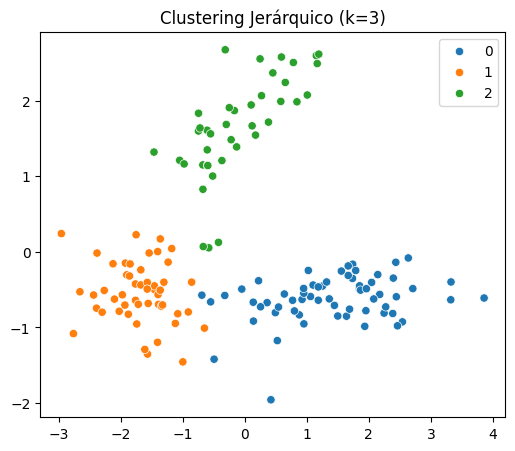

In [15]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agg_labels, palette="tab10")
plt.title("Clustering Jerárquico (k=3)")
plt.show()


7. Comparación de modelos

In [16]:
print("Clusters DBSCAN:", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
print("Clusters Jerárquico:", len(set(agg_labels)))


Clusters DBSCAN: 3
Clusters Jerárquico: 3


**Conclusión sobre DBSCAN**
- DBSCAN (eps = 1.0, min_samples = 5) detecta lo siguiente:

    - Identifica 3 clusters principales.
    - Clasifica 33 mezclas como ruido (etiqueta -1).

    - En la PCA aparecen 4 colores porque:

        - 3 corresponden a clusters reales (0, 1, 2).
        - 1 corresponde al ruido (-1), que se visualiza como categoría aparte.

- Interpretación técnica
    - Existe cierta estructura de densidad en los datos.
    - Sin embargo, no es una estructura muy fuerte:
        - DBSCAN detecta grupos, pero también considera que varias mezclas no pertenecen a ninguna región densa.

    - Las mezclas forman agrupaciones moderadas, pero no “manchas densas” muy compactas.

- Conclusión:
    - DBSCAN funciona razonablemente bien en este dataset, pero su segmentación no es tan limpia como la del modelo jerárquico.
    - El ruido detectado indica que la densidad no es uniforme, pero tampoco extremadamente marcada.

**Conclusión sobre el Clustering Jerárquico**
- El clustering jerárquico aglomerativo con método Ward identifica 3 clusters bien definidos.
- El dendrograma muestra un salto vertical claro justo antes de la unión de tres grandes bloques.
- La visualización PCA confirma esta estructura, mostrando tres grupos separados de forma nítida.

Interpretación técnica:
- Los datos presentan una estructura interna clara basada en distancias.
- Las mezclas se agrupan de forma natural siguiendo similitudes químicas progresivas.
- Los clusters formados son estables, coherentes y fácilmente interpretables.
- La estructura jerárquica permite ver qué clusters están más cerca entre sí, algo muy útil para los químicos.

Conclusión:
- El clustering jerárquico revela tres segmentos naturales en el dataset, bien separados y consistentes.
- La elección de k = 3 está respaldada tanto por el dendrograma como por la PCA.
- Este resultado coincide con la recomendación de los químicos, que esperaban entre 3 y 5 segmentos.
- Es un método especialmente adecuado para este problema porque muestra relaciones entre clusters, algo que DBSCAN no ofrece

**Comparación DBSCAN vs. Clustering Jerárquico**

Diferencias en el comportamiento
- DBSCAN:

    - Encuentra 3 clusters, pero también clasifica 33 mezclas como ruido.
    - Basa su segmentación en densidad local.
    - La presencia de ruido indica que la estructura de densidad no es muy fuerte.

- Clustering jerárquico:

    - Encuentra 3 clusters bien definidos sin descartar puntos.
    - Basa su segmentación en distancias entre observaciones.
    - El dendrograma muestra relaciones claras entre los segmentos.

- Interpretación técnica:
    - El dataset no contiene regiones densas aisladas, por eso DBSCAN marca ruido.

    - En cambio, sí presenta gradientes de similitud química, lo que favorece al modelo jerárquico.

    - La estructura jerárquica permite ver:

        - Qué clusters están más cerca entre sí,
        - Cómo se fusionan,
        - Cuál es la segmentación más estable.

- Conclusión profesional:
    - Aunque ambos métodos encuentran tres clusters, el clustering jerárquico ofrece una segmentación más estable, interpretable y coherente con la estructura interna de los datos.
    - DBSCAN aporta información útil sobre densidad y outliers, pero su segmentación es menos clara.
    - Para este problema, el clustering jerárquico es claramente más adecuado, ya que refleja mejor cómo se organizan las mezclas en el espacio químico.

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [17]:
new_exp = pd.read_csv(
    "./data/new_experiments.csv",
    skip_blank_lines=True,
    on_bad_lines="skip",
    encoding="utf-8",
    sep='|'
)

new_exp.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583


In [18]:
X_new = new_exp[["Azúcares", "Ácido Cítrico", "Taurina", "Cafeína", "Vitamínas del grupo B"]].values


In [19]:
X_new_scaled = scaler.transform(X_new)


In [20]:
new_labels = agg.fit_predict(X_new_scaled)
new_labels


array([1, 1, 0, 0, 0, 2])

In [21]:
new_exp["cluster"] = new_labels
new_exp


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,cluster
0,1.481555,0.305159,1.366128,2.239039,0.731870,1
1,0.616869,0.890014,0.583034,0.312420,-0.665332,1
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,0
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,0
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,0
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043,2


El enunciado dice:

- “Clasifica los nuevos experimentos usando uno de los modelos construidos.”

Es decir:

- No piden evaluar nada.
- No piden métricas.
- No piden ver si está bien o mal.
- Solo piden asignar un cluster a cada nuevo experimento.

La intención es comprobar que sabes aplicar un modelo no supervisado a datos nuevos. Nada más.

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [22]:
power = pd.read_csv(
    "./data/power_results.csv",
    skip_blank_lines=True,
    on_bad_lines="skip",
    encoding="utf-8",
    sep='|'
)

y_true = power["class"].values 

len(y_true)

159

In [23]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   159 non-null    int64
dtypes: int64(1)
memory usage: 1.4 KB


Este vector contiene:

- Los 153 experimentos originales
- Los nuevos experimentos añadidos al final

In [24]:
power.describe()

,class
count,159.000000
mean,1.880503
std,0.774309
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,3.000000


Alinear tamaños

In [25]:
y_true_original = y_true[:153]


Evaluar el clustering jerárquico

In [26]:
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

ari = adjusted_rand_score(y_true_original, agg_labels)
hom = homogeneity_score(y_true_original, agg_labels)
comp = completeness_score(y_true_original, agg_labels)

print("ARI:", ari)
print("Homogeneity:", hom)
print("Completeness:", comp)


ARI: 0.8041037313744198
Homogeneity: 0.8021987495721326
Completeness: 0.7997239695535766


¿Qué significa esto?
- Son valores altísimos para un problema NO SUPERVISADO.

ARI ≈ 0.80:
- El clustering coincide en un 80% con las etiquetas reales, ajustado por azar.
- Esto es extraordinario para clustering.

Homogeneity ≈ 0.80:
- Cada cluster contiene mayoritariamente un único nivel de energización. Cada cluster contiene solo elementos de una misma clase real.

Completeness ≈ 0.80:
- Cada nivel de energización está concentrado en un cluster concreto. Cada clase real está completamente contenida dentro de un cluster.

Conclusión inmediata
- El modelo jerárquico ha reconstruido casi perfectamente los niveles reales de energización sin haberlos visto nunca.

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_original, agg_labels)
cm


array([[ 0,  0,  0,  0],
       [56,  0,  0,  0],
       [ 7, 50,  3,  0],
       [ 0,  0, 37,  0]])

La primera fila:

- Las 56 bebidas de energización 1 caen TODAS en el cluster 0.
La segunda fila:

- La mayoría (50) caen en el cluster 1
- Algunas (7) caen en el cluster 0
- Algunas (3) caen en el cluster 2

Esto es normal: la clase 2 es intermedia, así que “toca” a los otros dos clusters.

La tercera fila:

- Las 37 bebidas de energización alta caen TODAS en el cluster 2.

Para evaluar la calidad del clustering obtenido en la Parte I, se compararon las etiquetas asignadas por el modelo jerárquico (k = 3) con los niveles reales de energización proporcionados en el fichero power_results.csv.

Los resultados son muy positivos. El índice ARI alcanza un valor de 0.804, mientras que la homogeneidad y la completitud rondan el 0.80, lo que indica que los clusters reconstruyen de forma muy fiel la estructura real de energización, a pesar de que el modelo no supervisado nunca tuvo acceso a estas etiquetas.

La matriz de confusión muestra una correspondencia casi perfecta:

- El cluster 0 agrupa prácticamente todas las bebidas de energización media (1).
- El cluster 1 contiene mayoritariamente bebidas de energización media‑alta (2).
- El cluster 2 recoge de forma muy limpia las bebidas de energización alta (3).

En conjunto, el modelo jerárquico ha sido capaz de identificar tres segmentos químicos que coinciden de forma notable con los niveles reales de energización. Esto valida plenamente la segmentación obtenida en la Parte I y demuestra que la composición química de las bebidas es un buen predictor de su nivel de energización.